## Introduction

Financial sector has emerged as the benchmark in leveraging the potential of data analtytics and machine learning to not only improve operations but to also proactively minimise the risks.

Our primary goal is to use data science tool as predictive modelling to build a strong framework capable of predicting loan outcomes.Our technique has the potential to help financial institutions to make more informed lending decisions.

SuperLender uses data driven a data-driven approach to assess the credit risk of its customers and determine the two fundermental drivers of repayment; `willingness` and `ability`.We will explore how SuperLender uses machine learning models to predict loan outcomes and evaluate their performance


### Business Understanding

Defaulting borrowers cause significant financial losses, impacting profit margins and liquidity ultimately affecting long-term business sustainability. Moreover, loan defaults can tarnish a company's reputation, erode investor confidence, and hinder future borrowing opportunities. 

Super Lender a local digital lending company seeks to provide effective credit risk model which determines borrower’s chances of repaying a loan. In this project we seek to develop a credit risk model employing machine learning techniques. The model assesses historical data to predict potential defaults, enabling proactive risk management. Also the model informs credit manager and the institution’s employees on borrower important details to enable data driven decisions not only to deny or advance a loan  but targeted strategies, including personalized loan terms.

### Problem Statement

A defaulted loan is an expense to the business. There is a need for financial institutions to enhance their risk assessment strategies and only lend responsibly.  As such predicting customer loan defaults is central to minimizing financial risks and ensuring sustainable lending practices. Chances of customer paying their loan are influenced by demographics and past financial details. The challenge is for financial institutions to distinguish customers who can pay loans and only lend to them.

### Main Objective

To develop a model which predicts customer loan repayment chances

#### Specific Objective

* Determine which demographic factors affects customer loan repayment chances
*	Determine which past financial details and behavior affects customer loan repayment chances
*	To develop a UI which informs credit manager on customer’s loan repayment details. 

## Data Understanding

We will make use of the datasets from Zindi, which is the largest professional network for data scientists in Africa.In particular we will be focusing on  3 different datasets for both train and test.

> a) Demographic data
* customerid(primary key)
* birthdate (date of birth of the customer)
* bank_account_type (type of primary bank account)
* latitude_gps / longitude_gps
* bank_name_clients (name of the bank)
* bank_branch_clients(location of the branch)
* employment_status_clients
* level_of_education_clients (highest level of education)

> b) Perfomance data
* customerid(primary key)
* systemloanid(id associated with the particular loan)
* loannumber(number of loan we are predicting)
* approveddate(date loan was approved)
* loan amount
* totaldue
* termdays
* refferedby
* good_bad_flag(good = settled loan on time; bad = did not settled loan on time)

> c) Previous loans data
* customerid
* systemloanid
* loannumber(the number of the loan that we will predict)
* approveddate
* creationdate(date the loan was created)
* loanamount
* totaldue
* closeddate
* refferedby
* firstduedate
* firstpaiddate


### Importing Libraries

In [1]:
# Wrangling
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None)

# Visulizing
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import chi2_contingency

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay, auc
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [16]:
# settings for all images
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (9.7, 6.27),
}
sns.set_theme(style="white", palette=None, rc=custom_params)
sns.set_context("notebook", font_scale=1.0)

In [6]:
# Loading the datasets
train_demographics = pd.read_csv("data/traindemographics.csv")
train_perf = pd.read_csv("data/trainperf.csv")
train_prev_loans = pd.read_csv("data/trainprevloans.csv")

### Preview of Datasets

In [3]:
train_demographics.head(2)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN


In [4]:
train_perf.head(2)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good


In [5]:
train_prev_loans.head(2)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000


In [6]:
#checking the shapes of the train data
print (train_demographics.shape)
print (train_perf. shape)
print (train_prev_loans.shape)

(4346, 9)
(4368, 10)
(18183, 12)


## Data Preprocessing
* The data is  demographics data is enhanced before merging by creating customer location from coordinates 

In [8]:
	
def add_cities(train_demographics):
    city_polygons_file = 'city_polygons.geojson'
    ndf = gpd.read_file(city_polygons_file)
    
    df = train_demographics.copy()
    final_df = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(train_demographics['longitude_gps'], train_demographics['latitude_gps'])
    )

    result_gdf = gpd.sjoin_nearest(final_df, ndf, how='left', distance_col='distances')

    cols_to_drop = ['geometry', 'index_right', 'state_id', 'distances']

    result_gdf.drop_duplicates(subset=['customerid'], inplace=True)

    return result_gdf.drop(columns=cols_to_drop)

# Call the function with train_demographics dataset
train_demographics_with_cities = add_cities(train_demographics)

train_demographics_with_cities['customer_residency'] = train_demographics_with_cities.apply(
    lambda row: row['state_name'] if row['country_name'].lower() == 'nigeria' else 'diaspora',
    axis=1
)
# Drop the coordinates
train_demographics_with_cities.drop(columns=['longitude_gps', 'latitude_gps'], inplace=True)

The `trainperf` and `train_prev_loans` have same columns names. The columns names are renamed by adding `.perf` and `.prev`

In [9]:
columns_to_update = ['systemloanid', 'loannumber', 'approveddate', 'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby']
train_perf.columns = [col + '.perf' if col in columns_to_update else col for col in train_perf.columns]

train_prev_loans.columns = [col + '.prev' if col in columns_to_update else col for col in train_prev_loans.columns]
print (train_perf. columns)
print(train_prev_loans.columns)

Index(['customerid', 'systemloanid.perf', 'loannumber.perf',
       'approveddate.perf', 'creationdate.perf', 'loanamount.perf',
       'totaldue.perf', 'termdays.perf', 'referredby.perf', 'good_bad_flag'],
      dtype='object')
Index(['customerid', 'systemloanid.prev', 'loannumber.prev',
       'approveddate.prev', 'creationdate.prev', 'loanamount.prev',
       'totaldue.prev', 'termdays.prev', 'closeddate', 'referredby.prev',
       'firstduedate', 'firstrepaiddate'],
      dtype='object')


### Merging the train data

In [10]:
# Merging the training data using customer id as the key value
train_data = pd.merge(train_prev_loans, train_demographics_with_cities, on='customerid', how='left')
merged_data = pd.merge(train_data, train_perf, on='customerid', how='left')
merged_data.shape

(18183, 30)

In [11]:
# Displaying the merged data dataset
merged_data.head(2)

,customerid,systemloanid.prev,loannumber.prev,approveddate.prev,creationdate.prev,loanamount.prev,totaldue.prev,termdays.prev,closeddate,referredby.prev,firstduedate,firstrepaiddate,birthdate,bank_account_type,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,state_name,country_name,customer_residency,systemloanid.perf,loannumber.perf,approveddate.perf,creationdate.perf,loanamount.perf,totaldue.perf,termdays.perf,referredby.perf,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate,Lagos,Nigeria,Lagos,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15 00:00:00.000000,Other,Diamond Bank,NaN,Permanent,Post-Graduate,Lagos,Nigeria,Lagos,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good


In [14]:
# Getting statistics about the data
merged_data.describe(include='number')

,systemloanid.prev,loannumber.prev,loanamount.prev,totaldue.prev,termdays.prev,systemloanid.perf,loannumber.perf,loanamount.perf,totaldue.perf,termdays.perf
count,1.818300e+04,18183.000000,18183.000000,18183.000000,18183.000000,1.818300e+04,18183.000000,18183.000000,18183.000000,18183.000000
mean,3.018395e+08,4.189353,16501.237420,19573.202931,26.692790,3.019804e+08,8.378320,25663.531870,29795.094627,33.344333
std,9.367767e+04,3.249490,9320.547516,10454.245277,10.946556,1.343207e+04,4.283426,12647.370172,13814.433300,14.703428
min,3.016001e+08,1.000000,3000.000000,3450.000000,15.000000,3.019585e+08,2.000000,10000.000000,10000.000000,15.000000
25%,3.017766e+08,2.000000,10000.000000,11500.000000,15.000000,3.019681e+08,5.000000,10000.000000,13000.000000,30.000000
50%,3.018550e+08,3.000000,10000.000000,13000.000000,30.000000,3.019793e+08,8.000000,30000.000000,33000.000000,30.000000
75%,3.019197e+08,6.000000,20000.000000,24500.000000,30.000000,3.019930e+08,11.000000,40000.000000,44000.000000,30.000000
max,3.020003e+08,26.000000,60000.000000,68100.000000,90.000000,3.020040e+08,27.000000,60000.000000,68100.000000,90.000000


In [15]:
merged_data.describe(exclude='number')

,customerid,approveddate.prev,creationdate.prev,closeddate,referredby.prev,firstduedate,firstrepaiddate,birthdate,bank_account_type,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,state_name,country_name,customer_residency,approveddate.perf,creationdate.perf,referredby.perf,good_bad_flag
count,18183,18183,18183,18183,1026,18183,18183,13673,13673,13673,104,12310,3464,13673,13673,13673,18183,18183,1026,18183
unique,4359,18172,18173,17955,521,363,18011,2635,3,18,28,6,4,58,14,37,4353,4355,521,2
top,8a858f7d5578012a01557ea194d94948,2017-04-20 14:00:44.000000,2017-06-12 10:38:36.000000,2016-11-07 00:53:42.000000,8a858fc55b2548dd015b286e452c678c,2017-07-03 00:00:00.000000,2016-08-04 00:00:00.000000,1976-02-28 00:00:00.000000,Savings,GT Bank,"BOSSO ROAD, MINNA",Permanent,Graduate,Lagos,Nigeria,Lagos,2017-07-13 03:42:40.000000,2017-07-13 02:42:33.000000,8a858fc55b2548dd015b286e452c678c,Good
freq,26,2,2,5,14,398,7,29,8291,5028,15,9118,2508,6321,13514,6321,26,26,14,14815


## Data Cleaning

In this crucial phase, we address various data quality issues to ensure the reliability and integrity of our dataset. Our data cleaning process includes:

1. **Handling Missing Values:** We carefully handle missing values, employing techniques such as imputation or removal to prevent data gaps from affecting our analysis.

2. **Outlier Detection:** We systematically check for outliers in our dataset, identifying data points that deviate significantly from the norm. Addressing outliers is essential to maintain the accuracy of our analyses.

3. **Duplicate Detection:** We meticulously scan for duplicate records and, if found, take appropriate actions to eliminate redundant entries, ensuring that our data remains unique and representative.

Data cleaning is the foundational step to ensure the quality and trustworthiness of the data we use for analysis and modeling.


In [17]:
# Create 'referredby' column by combining 'referredby.perf' and 'referredby.prev', replacing missing values with 0
merged_data['referredby'] = (merged_data['referredby.perf'].notnull()).astype(int) + (merged_data['referredby.prev'].notnull()).astype(int)

# Optionally, drop the intermediate columns if needed
merged_data = merged_data.drop(['referredby.perf', 'referredby.prev'], axis=1)

#### Checking for Missing Values

In [18]:
#Check for missing values in each column
missing_values = merged_data.isnull().sum()

# Calculate the percentage of missing values
percentage_missing_values = (missing_values / len(merged_data)) * 100

# Create a DataFrame to display missing values and percentages
missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': percentage_missing_values
})

# Sort the DataFrame by 'Percentage' column in descending order
sorted_missing_data = missing_data_summary.sort_values(by='Percentage', ascending=False)

print("Missing values summary sorted by percentage in descending order:")
print(sorted_missing_data[sorted_missing_data['Missing Values'] > 0]) # only view missing

Missing values summary sorted by percentage in descending order:
                            Missing Values  Percentage
bank_branch_clients                  18079   99.428037
level_of_education_clients           14719   80.949238
employment_status_clients             5873   32.299401
state_name                            4510   24.803388
customer_residency                    4510   24.803388
birthdate                             4510   24.803388
bank_account_type                     4510   24.803388
bank_name_clients                     4510   24.803388
country_name                          4510   24.803388


* `bank_branch_clients` have 99% missing values hence they are dropped.   
*  Even though `level_of_education_clients`, `employment_status_clients `, `customer_residency`,  `bank_account_type` , `birthdate`, `bank_name_clients` have between 24% and 80% missing values, they are kept as they have important demographic information.

In [19]:
# Dropping columns with missing values as indicated above 
merged_data.drop(columns=['bank_branch_clients'], inplace=True)     

### Checking for outliers

In [20]:
columns_to_check = ['loanamount.prev', 'totaldue.prev', 'termdays.prev', 'loanamount.perf', 'totaldue.perf', 'termdays.perf']

# Identify outliers using IQR method
def find_outliers(column_data):
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]
    return outliers

for column in columns_to_check:
    outliers = find_outliers(merged_data[column])
    num_outliers = len(outliers)
    print(f" Number of Outliers {column}  {num_outliers}")

 Number of Outliers loanamount.prev  978
 Number of Outliers totaldue.prev  676
 Number of Outliers termdays.prev  1023
 Number of Outliers loanamount.perf  0
 Number of Outliers totaldue.perf  0
 Number of Outliers termdays.perf  5240


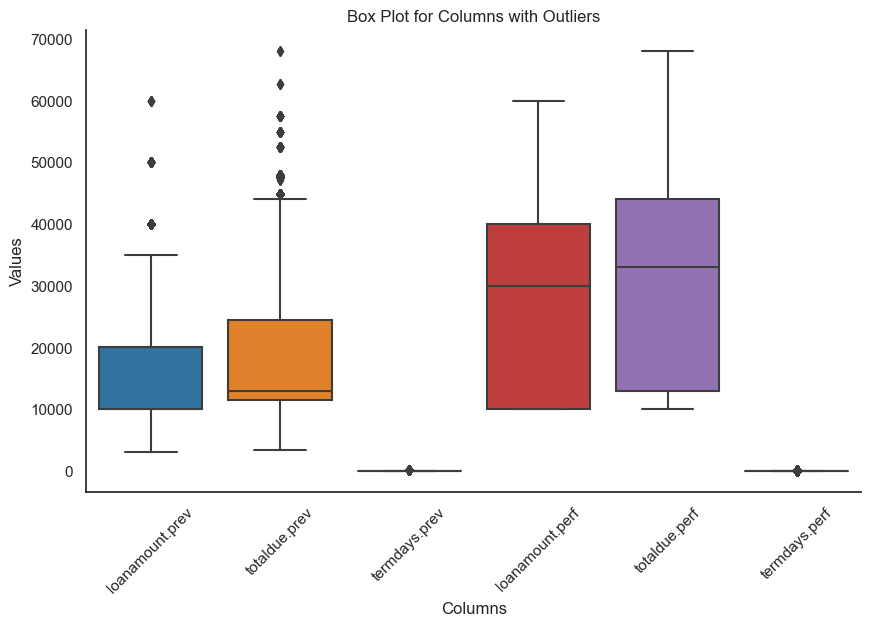

In [21]:
# List of columns to check for outliers
columns_to_check = ['loanamount.prev', 'totaldue.prev', 'termdays.prev', 'loanamount.perf', 'totaldue.perf', 'termdays.perf']

# Create box plots for each column
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data[columns_to_check])
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot for Columns with Outliers')
plt.show()

* The data  has outliers. However, domain knowledge shows that its expected where people borrow different amount of loans. The outliers are true events hence were included in the data 

### Check for  Row Duplicates

In [22]:
duplicates = merged_data.duplicated(keep=False).sum()
print("Number of duplicated rows in merged_data:", duplicates)

Number of duplicated rows in merged_data: 0


## Exploratory Data Analysis

In this phase, our primary goal is to unveil essential patterns and factors that are closely linked to loan repayment behavior. To achieve this, we employ a combination of techniques, including univariate and bivariate analysis.

- **Univariate Analysis:** This initial step involves the examination of variables individually to comprehend their distributions. It helps us gain insights into the central tendencies, dispersions, and general characteristics of each feature.

- **Bivariate Analysis:** In the bivariate analysis stage, we delve deeper into exploring the relationships between each variable and the target variable, which is loan repayment behavior in our case. This process allows us to identify how various factors correlate with the target variable and potentially influence loan repayment.

Through these analytical approaches, we aim to uncover key insights and uncover the driving forces behind loan repayment behavior, which is pivotal for making informed decisions and building robust predictive models.

### Univariate Analysis

#### Numeric Variables

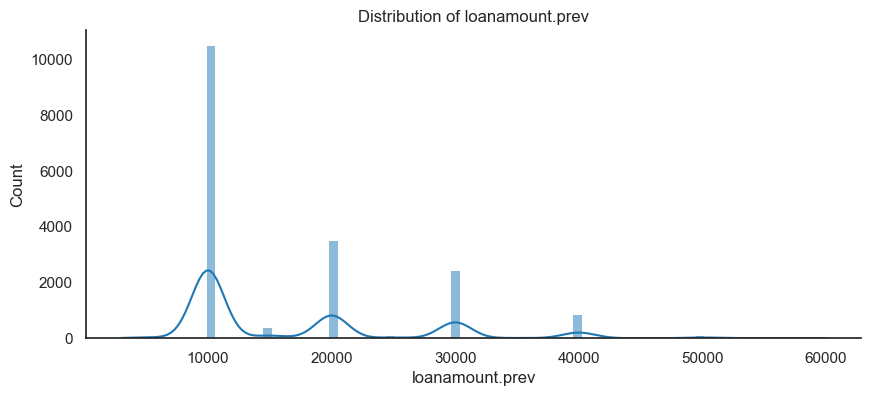

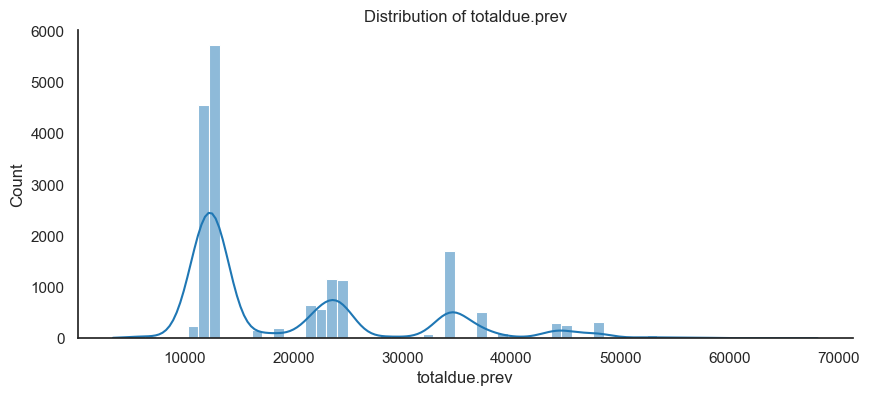

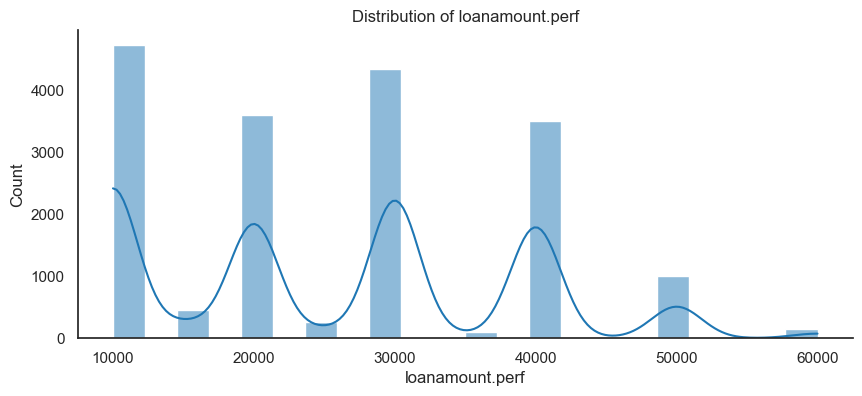

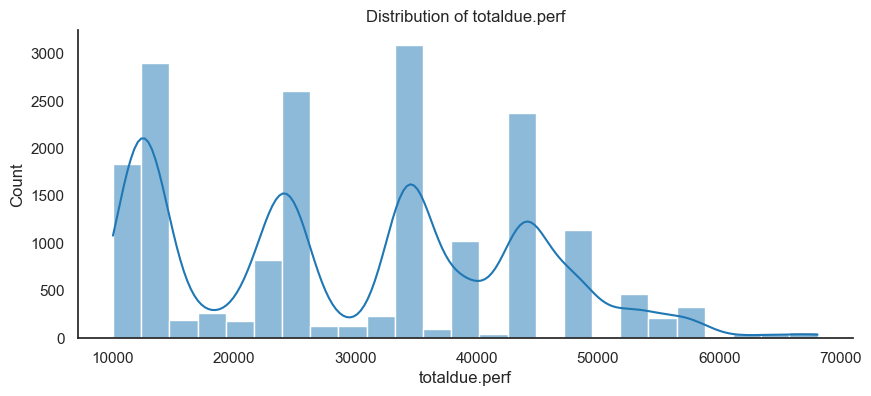

In [24]:
# Check distribution of numerical features
num_fts = ['loanamount.prev', 'totaldue.prev', 'loanamount.perf', 'totaldue.perf']
for ft in num_fts:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=merged_data, x=ft, kde=True)
    plt.title(f"Distribution of {ft}");

#### Interpretation of Results

Upon a thorough examination of our data, we've uncovered some key observations:

- **Loan Amount Distribution:** The feature `loanamount.prev` displays a significant right-skewness, indicating that the majority of customers tend to opt for smaller loans, with a predominant choice of around $10,000. This suggests that our customers typically lean towards more conservative borrowing.

- **Remaining Numeric Features:** Similar to `loanamount.prev`, all other numeric features in our dataset exhibit a right-skewed distribution. This shared characteristic hints at a consistent trend across these variables, reinforcing the observation of conservative customer behavior in various aspects of our data.

It's notable that our numeric variables exhibit behavior similar to categorical variables in our dataset. Given this characteristic, representing these numeric variables as categorical may prove to be a more effective approach for our analysis. This transformation can provide a clearer understanding of how these variables relate to loan repayment behavior and other aspects of our data.


In [30]:
def create_categorical_columns(dataframe):
    bins = [i for i in range(0, 10000, 10000)] + [i for i in range(10000, int(dataframe['loanamount.prev'].max()) + 10000, 10000)]
    labels = [f'{i}-{i+9999}' for i in range(0, 10000, 10000)] + [f'{i}-{i+9999}' for i in range(10000, int(dataframe['loanamount.prev'].max()) + 10000, 10000)]
    categorical_columns = ['loanamount.prev', 'totaldue.prev', 'loanamount.perf', 'totaldue.perf']
    
    for column in categorical_columns:
        new_column_name = f'{column}_categorical'
        dataframe[new_column_name] = pd.cut(dataframe[column].astype(int), bins, labels=labels[:-1], right=False)
    
    return dataframe
merged_data = create_categorical_columns(merged_data)

#### Categorical Variables

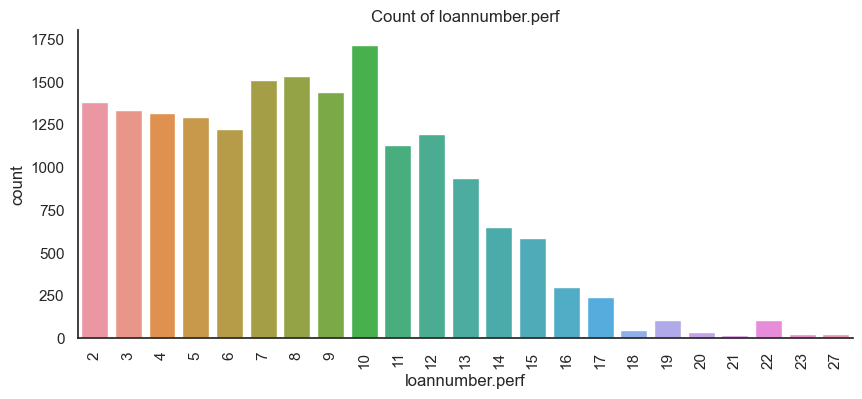

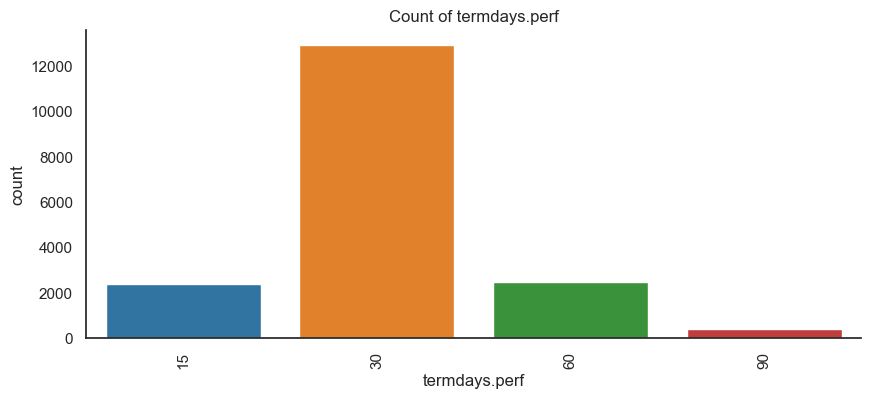

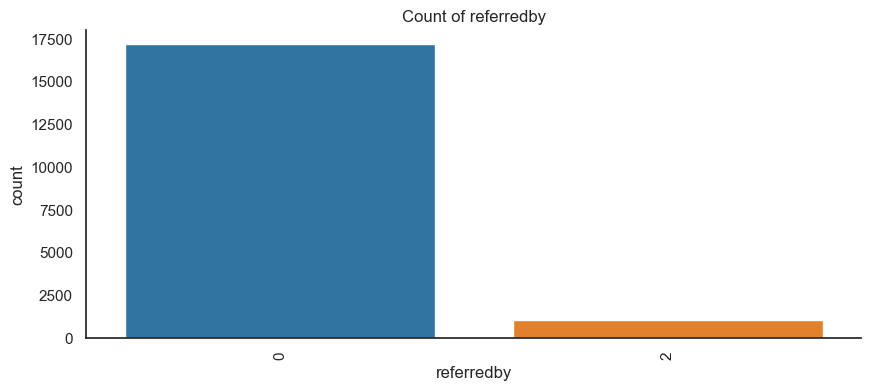

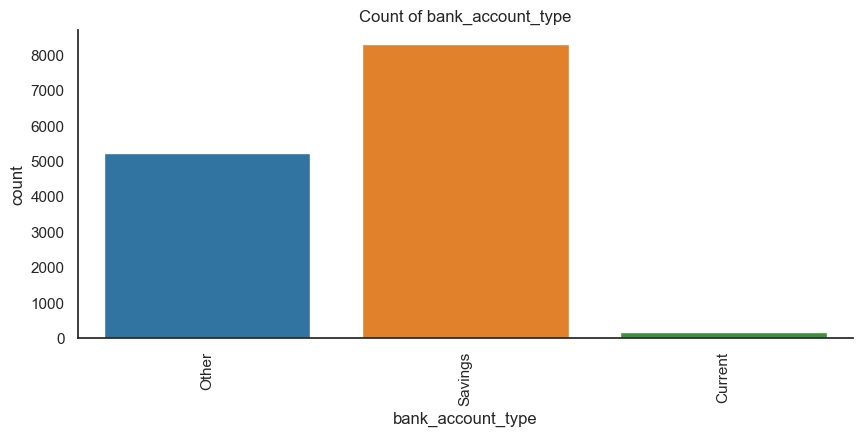

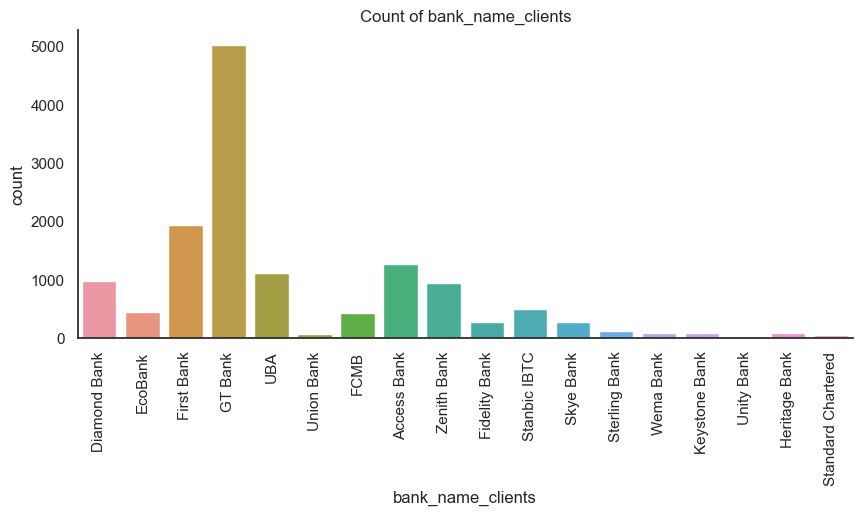

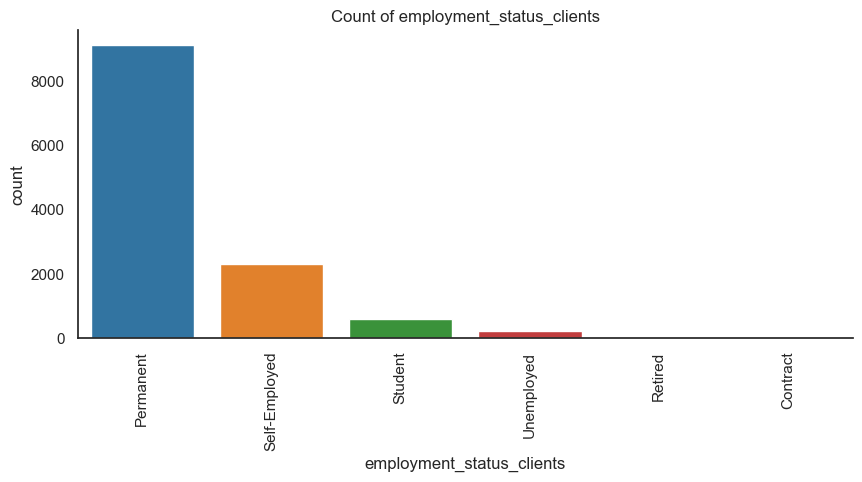

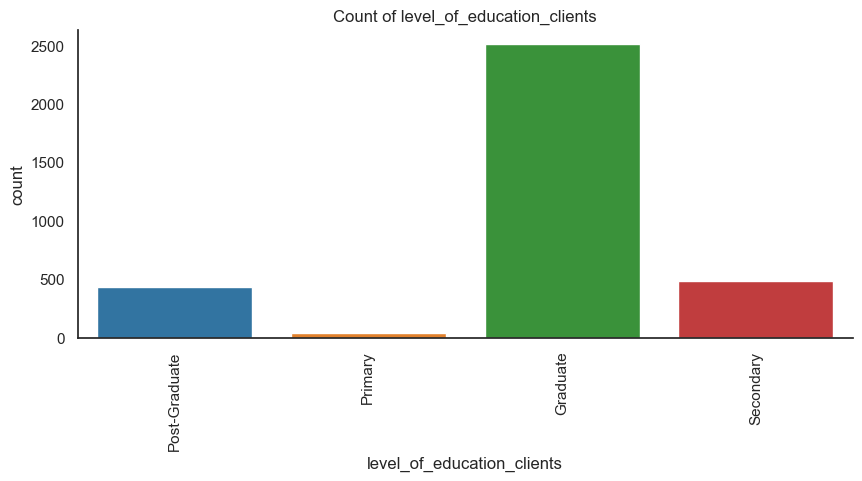

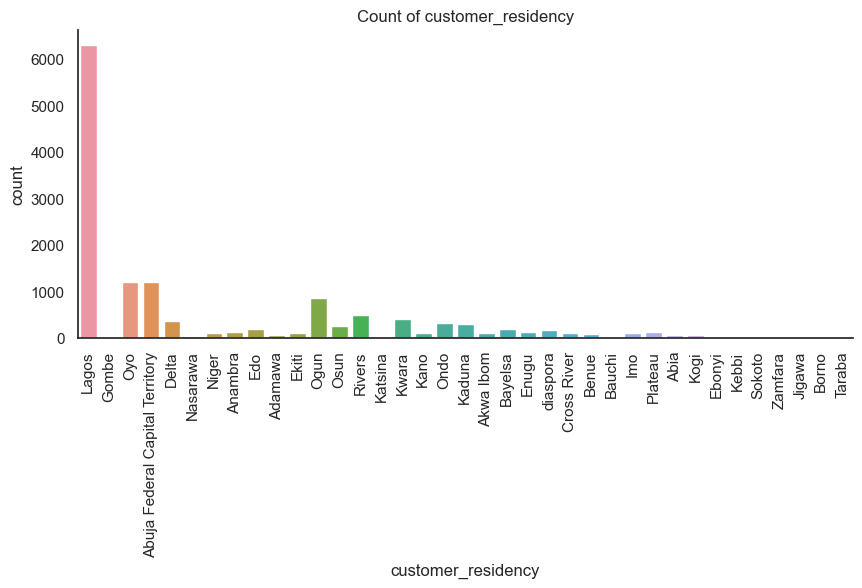

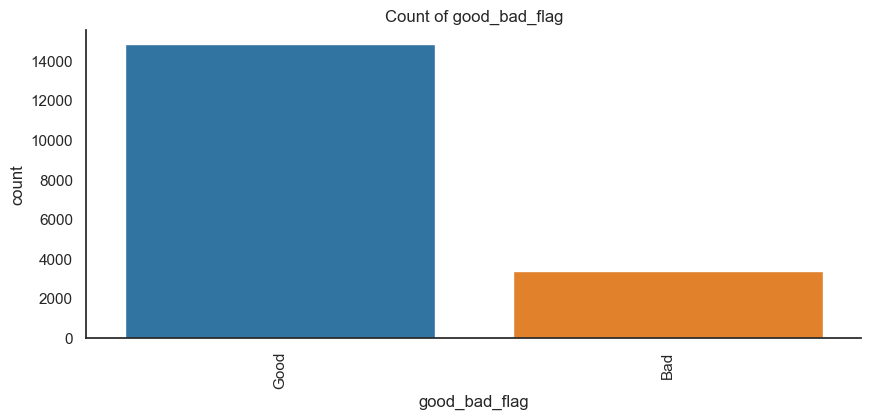

In [29]:
cat_fts = ['loannumber.perf', 'termdays.perf', 'referredby', 'bank_account_type', 'bank_name_clients', 'employment_status_clients',
           'level_of_education_clients', 'customer_residency', 'good_bad_flag']

for ft in cat_fts:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=merged_data, x=ft)
    plt.title(f'Count of {ft}')
    plt.xticks(rotation=90);

##### Interpretation of Results

Our data provides valuable insights into the characteristics of our customers and their interactions with our loan services:

- **Loannumber.perf:** The distribution of `loannumber.perf` highlights a significant presence of return customers, suggesting a positive customer experience and loyalty to our services.

- **Termdays.perf:** The majority of loans we offer have a 30-day repayment term, indicating that most customers opt for this duration.

- **Referredby:** It's evident that most of our customers have not been referred to us, signifying that we have a broad customer base that isn't dependent on referrals.

- **Bank_account_type:** The majority of customers hold savings accounts, reflecting a common financial preference among our clientele.

- **Bank_name_clients:** Customers primarily bank with GT Bank, with the remaining customers distributed fairly evenly among other banks.

- **Employment_status_clients:** Most of our customers currently hold permanent employment, indicating financial stability.

- **Level_of_education_clients:** The majority of customers are graduates, with only a small proportion having primary-level education.

- **Customer_residency:** A significant number of our customers are based in Lagos, while the rest are somewhat evenly distributed across the country.

- **Good_bad_flag:** Most of our customers fall into the "good" category, suggesting that a substantial portion of our customer base consistently meets their loan obligations and does not default.

### Bivariate Analysis

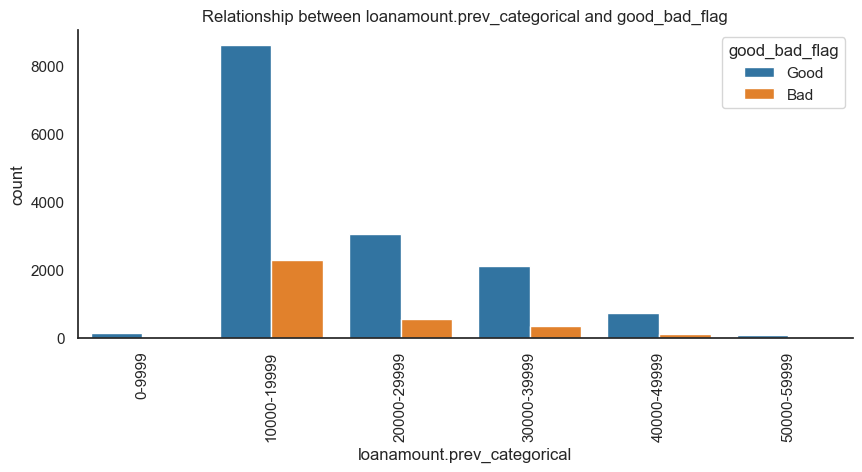

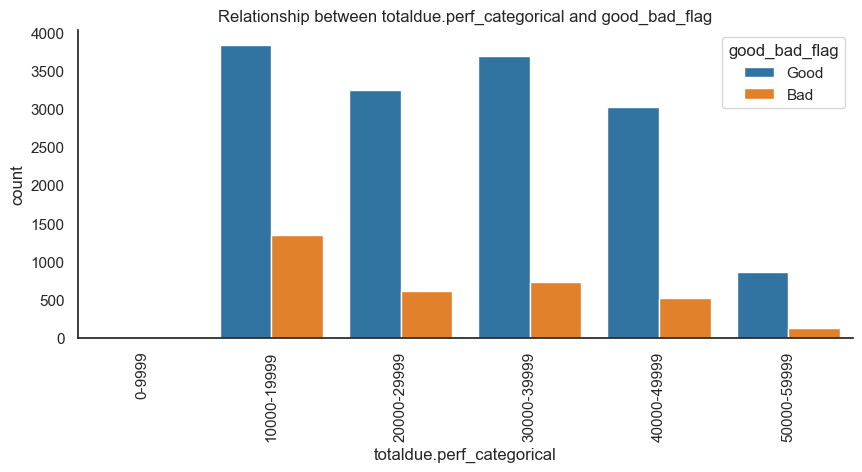

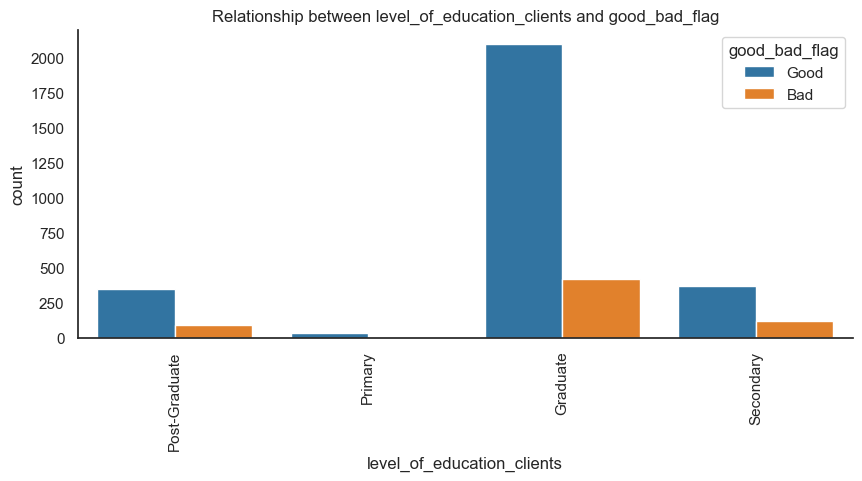

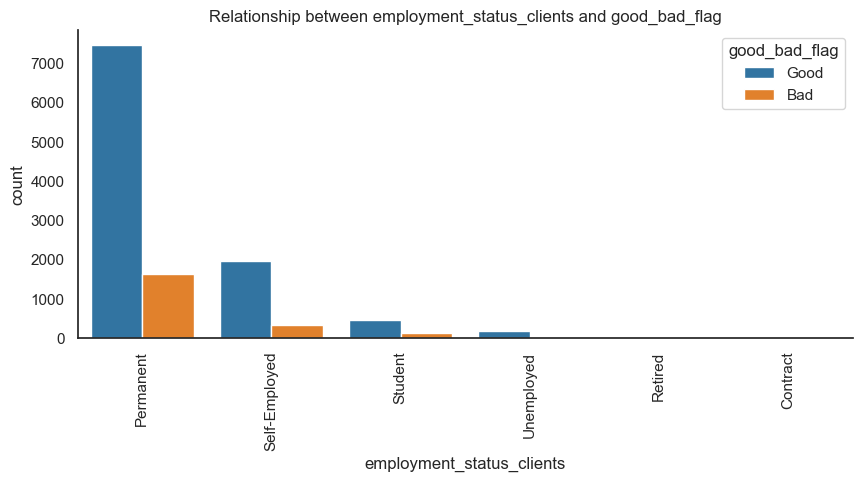

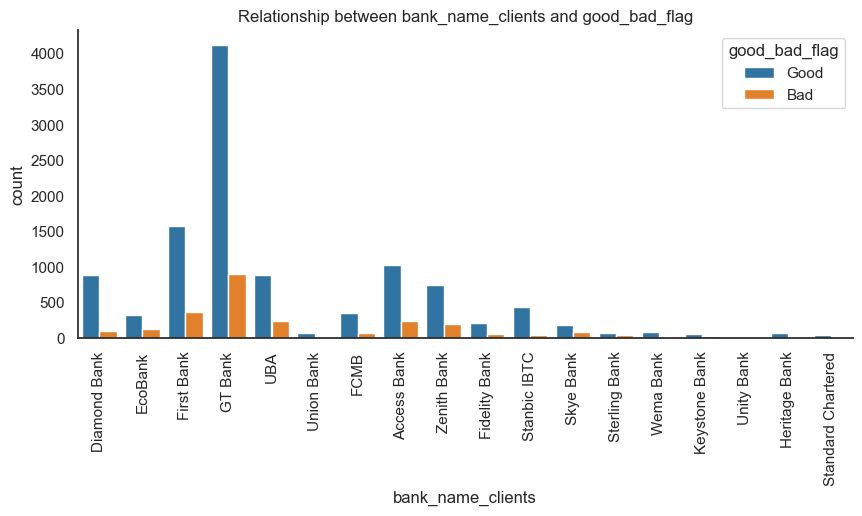

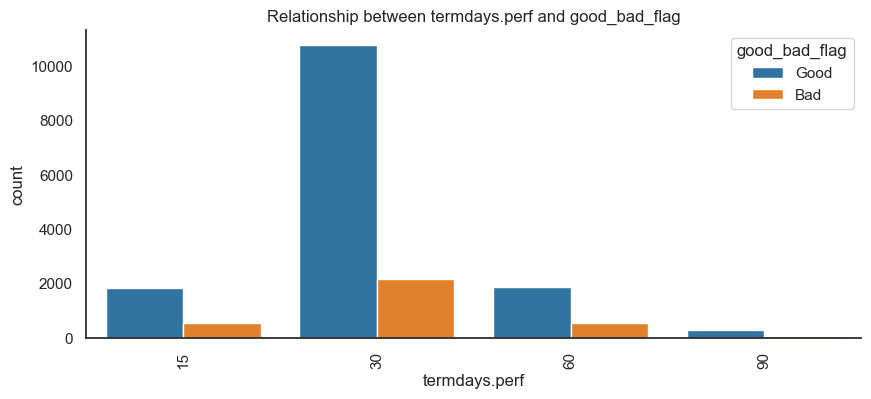

In [32]:
selected_vars = ['loanamount.prev_categorical', 'totaldue.perf_categorical', 'level_of_education_clients',
                 'employment_status_clients', 'bank_name_clients', 'termdays.perf']
label = 'good_bad_flag'
for var in selected_vars:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=merged_data, x=var, hue=label)
    plt.title(f"Relationship between {var} and {label}")
    plt.xticks(rotation=90);

#### Interpretation of Results

Visual analysis alone may not suffice to discern the impact of a feature on the `good_bad_flag` variable. To gain a more comprehensive understanding of these relationships, we intend to perform statistical tests, such as the chi-squared test. This statistical analysis will provide a more rigorous assessment of the effects of various features on the `good_bad_flag` variable, helping us uncover significant patterns and dependencies in our data.


In [36]:
for var in selected_vars:
    contingency = pd.crosstab(merged_data[label], merged_data[var])
    stat, p, dof, expected = chi2_contingency(contingency)
    alpha = 0.05
    print(var)
    print(f"p value is {p}")
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')
    print('-'*15)   
    

loanamount.prev_categorical
p value is 2.673137210676931e-21
Dependent (reject H0)
---------------
totaldue.perf_categorical
p value is 2.343780742075173e-57
Dependent (reject H0)
---------------
level_of_education_clients
p value is 9.9758562638087e-06
Dependent (reject H0)
---------------
employment_status_clients
p value is 5.912725356789864e-06
Dependent (reject H0)
---------------
bank_name_clients
p value is 1.5937981163530983e-30
Dependent (reject H0)
---------------
termdays.perf
p value is 1.307537765098535e-21
Dependent (reject H0)
---------------


Our statistical tests have revealed that our target variable, `good_bad_flag`, exhibits dependency on the selected features. This important finding emphasizes the impact of these features on the likelihood of a customer being categorized as "good" or "bad," offering valuable insights into the determinants of loan repayment behavior.


## Compute Credit Score
* The hypothesis testing showed significant relationship between demographic factors and loan details.
* The variables are used to compute credit score
* We assigned weight to each category based on the findings of contingency score. The idea is to give more weight to categories that have a stronger association with non-default. The higher the percentage of "Good" or non-default the higher the score assigned to that category


In [66]:
# Contingency tables
# Columns to analyze
columns_to_analyze = ['level_of_education_clients', 'employment_status_clients', 
                     'bank_name_clients', 'termdays.prev', 'termdays.perf', 'referredby', 
                     'state_name', 'bank_account_type', 'loanamount.prev_categorical',
       'totaldue.prev_categorical', 'loanamount.perf_categorical',
       'totaldue.perf_categorical']
value_counts_dict = {}

# Total counts and percentages for each column across 'good_bad_flag'
for column in columns_to_analyze:
    contingency_table = pd.crosstab(index=merged_data[column], columns=merged_data['good_bad_flag'])
    total_counts = contingency_table.sum(axis=1)
    percentages = (contingency_table.div(total_counts, axis=0) * 100).round(0).astype(int).astype(str) + '%'
    value_counts_dict[column] = percentages

# Percentages for each column
for column, percentages in value_counts_dict.items():
    print(f"Percentages for {column}:")
    print(percentages)
    print("==============================")

Percentages for level_of_education_clients:
good_bad_flag               Bad Good
level_of_education_clients          
Graduate                    17%  83%
Post-Graduate               20%  80%
Primary                      3%  97%
Secondary                   25%  75%
Percentages for employment_status_clients:
good_bad_flag              Bad  Good
employment_status_clients           
Contract                    0%  100%
Permanent                  18%   82%
Retired                     0%  100%
Self-Employed              15%   85%
Student                    23%   77%
Unemployed                 18%   82%
Percentages for bank_name_clients:
good_bad_flag       Bad Good
bank_name_clients           
Access Bank         19%  81%
Diamond Bank        10%  90%
EcoBank             30%  70%
FCMB                18%  82%
Fidelity Bank       22%  78%
First Bank          19%  81%
GT Bank             18%  82%
Heritage Bank       14%  86%
Keystone Bank       27%  73%
Skye Bank           31%  69%
Stanbic IBTC

In [83]:
# Function to assign credit scores
def assign_credit_score(percentages):
    credit_scores = {}
    for category, (bad_percentage, good_percentage) in percentages.items():
        # Assign higher scores to categories with higher 'Good' (non-default) percentages
        credit_scores[category] = good_percentage
    
    # Normalize credit scores to a scale of 1 to 100
    max_score = max(credit_scores.values())
    min_score = min(credit_scores.values())
    normalized_scores = {category: 1 + 99 * ((score - min_score) / (max_score - min_score)) for category, score in credit_scores.items()}
    
    return normalized_scores

columns_to_analyze = ['level_of_education_clients', 'employment_status_clients', 
                     'bank_name_clients', 'termdays.prev', 'termdays.perf', 'referredby', 
                     'state_name', 'bank_account_type', 'loanamount.prev_categorical',
                     'totaldue.prev_categorical', 'loanamount.perf_categorical',
                     'totaldue.perf_categorical']

value_counts_dict = {}
for column in columns_to_analyze:
    contingency_table = pd.crosstab(index=merged_data[column], columns=merged_data['good_bad_flag'])
    total_counts = contingency_table.sum(axis=1)
    percentages = (contingency_table.div(total_counts, axis=0) * 100).round(0).astype(int)
    value_counts_dict[column] = percentages

# Calculate and print credit scores for each column
for column, percentages_df in value_counts_dict.items():
    good_percentages = percentages_df['Good']
    
    percentages_tuple = good_percentages.apply(lambda x: (100 - x, x))
    credit_scores = assign_credit_score(percentages_tuple)
    print(f"Credit Scores for '{column}':")
    print(credit_scores)
    print("==============================")


Credit Scores for 'level_of_education_clients':
{'Graduate': 37.0, 'Post-Graduate': 23.5, 'Primary': 100.0, 'Secondary': 1.0}
Credit Scores for 'employment_status_clients':
{'Contract': 100.0, 'Permanent': 22.52173913043478, 'Retired': 100.0, 'Self-Employed': 35.43478260869565, 'Student': 1.0, 'Unemployed': 22.52173913043478}
Credit Scores for 'bank_name_clients':
{'Access Bank': 48.666666666666664, 'Diamond Bank': 81.66666666666666, 'EcoBank': 8.333333333333332, 'FCMB': 52.33333333333333, 'Fidelity Bank': 37.666666666666664, 'First Bank': 48.666666666666664, 'GT Bank': 52.33333333333333, 'Heritage Bank': 67.0, 'Keystone Bank': 19.333333333333332, 'Skye Bank': 4.666666666666666, 'Stanbic IBTC': 81.66666666666666, 'Standard Chartered': 100.0, 'Sterling Bank': 1.0, 'UBA': 41.33333333333333, 'Union Bank': 92.66666666666667, 'Unity Bank': 12.0, 'Wema Bank': 100.0, 'Zenith Bank': 41.33333333333333}
Credit Scores for 'termdays.prev':
{15: 1.0, 30: 20.8, 60: 30.7, 90: 100.0}
Credit Scores for

### Get maximum and minimum scores

In [90]:
# Initialize variables to store minimum and maximum scores
min_scores = {}
max_scores = {}
total_min_score = 0
total_max_score = 0
for column, percentages_df in value_counts_dict.items():
    good_percentages = percentages_df['Good']
    percentages_tuple = good_percentages.apply(lambda x: (100 - x, x))
    credit_scores = assign_credit_score(percentages_tuple)
    
    # Calculate minimum and maximum scores
    min_score = min(credit_scores.values())
    max_score = max(credit_scores.values())
    min_scores[column] = min_score
    max_scores[column] = max_score
    total_min_score += min_score
    total_max_score += max_score
print(f"Total Minimum Score: {total_min_score}")
print(f"Total Maximum Score: {total_max_score}")

Total Minimum Score: 12.0
Total Maximum Score: 1200.0


#### Categorization of  the credidt scores

In [88]:
# Function to categorize scores
def categorize_score(score):
    if score <= 400:
        return 'Poor'
    elif 401 <= score <= 600:
        return 'Fair'
    elif 601 <= score <= 750:
        return 'Good'
    elif 751 <= score <= 900:
        return 'Very Good'
    elif 901 <= score <= 1200:
        return 'Excellent'

## Data preprocessing

In [38]:
merged_data.isna().sum()

customerid                         0
systemloanid.prev                  0
loannumber.prev                    0
approveddate.prev                  0
creationdate.prev                  0
loanamount.prev                    0
totaldue.prev                      0
termdays.prev                      0
closeddate                         0
firstduedate                       0
firstrepaiddate                    0
birthdate                       4510
bank_account_type               4510
bank_name_clients               4510
employment_status_clients       5873
level_of_education_clients     14719
state_name                      4510
country_name                    4510
customer_residency              4510
systemloanid.perf                  0
loannumber.perf                    0
approveddate.perf                  0
creationdate.perf                  0
loanamount.perf                    0
totaldue.perf                      0
termdays.perf                      0
good_bad_flag                      0
r

In [39]:
# Dropping rows with missing values
merged_data.dropna(axis=0,inplace=True)
merged_data.isna().sum()

customerid                     0
systemloanid.prev              0
loannumber.prev                0
approveddate.prev              0
creationdate.prev              0
loanamount.prev                0
totaldue.prev                  0
termdays.prev                  0
closeddate                     0
firstduedate                   0
firstrepaiddate                0
birthdate                      0
bank_account_type              0
bank_name_clients              0
employment_status_clients      0
level_of_education_clients     0
state_name                     0
country_name                   0
customer_residency             0
systemloanid.perf              0
loannumber.perf                0
approveddate.perf              0
creationdate.perf              0
loanamount.perf                0
totaldue.perf                  0
termdays.perf                  0
good_bad_flag                  0
referredby                     0
loanamount.prev_categorical    0
totaldue.prev_categorical      0
loanamount

In [40]:
# Calculating the age of the customers
merged_data['birthdate'] = pd.to_datetime(merged_data['birthdate'])
merged_data['approveddate.perf'] = pd.to_datetime(merged_data['approveddate.perf'])

# Calculate age in years
merged_data['age'] = (merged_data['approveddate.perf'] - merged_data['birthdate']).dt.days // 365.25

# Display the DataFrame
merged_data.head()

,customerid,systemloanid.prev,loannumber.prev,approveddate.prev,creationdate.prev,loanamount.prev,totaldue.prev,termdays.prev,closeddate,firstduedate,firstrepaiddate,birthdate,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,state_name,country_name,customer_residency,systemloanid.perf,loannumber.perf,approveddate.perf,creationdate.perf,loanamount.perf,totaldue.perf,termdays.perf,good_bad_flag,referredby,loanamount.prev_categorical,totaldue.prev_categorical,loanamount.perf_categorical,totaldue.perf_categorical,age
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000,1972-01-15,Other,Diamond Bank,Permanent,Post-Graduate,Lagos,Nigeria,Lagos,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,0,10000-19999,10000-19999,30000-39999,30000-39999,45.0
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000,1972-01-15,Other,Diamond Bank,Permanent,Post-Graduate,Lagos,Nigeria,Lagos,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,0,10000-19999,10000-19999,30000-39999,30000-39999,45.0
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000,1972-01-15,Other,Diamond Bank,Permanent,Post-Graduate,Lagos,Nigeria,Lagos,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47.000000,30000.0,34500.0,30,Good,0,20000-29999,20000-29999,30000-39999,30000-39999,45.0
5,8a858970548359cc0154883481981866,301832407,5,2017-03-06 13:25:17.000000,2017-03-06 12:25:10.000000,20000.0,23800.0,30,2017-04-04 15:46:56.000000,2017-04-05 00:00:00.000000,2017-04-04 15:31:47.000000,1986-09-07,Other,GT Bank,Permanent,Primary,Abuja Federal Capital Territory,Nigeria,Abuja Federal Capital Territory,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39.000000,40000.0,44000.0,30,Good,0,20000-29999,20000-29999,40000-49999,40000-49999,30.0
6,8a858970548359cc0154883481981866,301926513,8,2017-06-04 01:00:23.000000,2017-06-04 00:00:16.000000,30000.0,39000.0,60,2017-07-03 23:35:38.000000,2017-07-04 00:00:00.000000,2017-07-03 23:25:29.000000,1986-09-07,Other,GT Bank,Permanent,Primary,Abuja Federal Capital Territory,Nigeria,Abuja Federal Capital Territory,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39.000000,40000.0,44000.0,30,Good,0,30000-39999,30000-39999,40000-49999,40000-49999,30.0


In [41]:
# Convert date columns to datetime objects
date_columns = ['approveddate.prev', 'creationdate.prev', 'approveddate.perf', 'creationdate.perf']
for col in date_columns:
    merged_data[col] = pd.to_datetime(merged_data[col], format='%Y-%m-%d %H:%M:%S.%f')

# Calculate time differences and convert to minutes
merged_data['time_to_approval.prev'] = (merged_data['approveddate.prev'] - merged_data['creationdate.prev']).dt.total_seconds() / 60
merged_data['time_to_approval.perf'] = (merged_data['approveddate.perf'] - merged_data['creationdate.perf']).dt.total_seconds() / 60

In [42]:
# Create categorical features based on employment stability
merged_data['employment_stability'] = 'Unknown'

# Categorize into 'Stable,' 'Unstable,' and 'Unknown'
merged_data.loc[merged_data['employment_status_clients'].isin(['Permanent', 'Retired']), 'employment_stability'] = 'Stable'
merged_data.loc[merged_data['employment_status_clients'].isin(['Self-Employed', 'Contract']), 'employment_stability'] = 'Unstable'
merged_data['employment_stability'] = merged_data['employment_stability'].map({'Stable': 1, 'Unstable': 2, 'Unknown': 3})
# Drop the original 'employment_status_clients' column if no longer needed
merged_data.drop(columns=['employment_status_clients'], inplace=True)

### Dropping Columns

In [43]:
# Dropping columns
columns_to_drop = [
    'customerid', 'systemloanid.prev', 'loannumber.prev', 'systemloanid.perf', 'loannumber.perf',
    'approveddate.prev', 'creationdate.prev', 'closeddate', 'firstduedate', 'birthdate',
    'approveddate.perf', 'creationdate.perf', 'firstrepaiddate', 'state_name',
    'country_name'
]
merged_data.drop(columns=columns_to_drop, inplace=True)


In [44]:
merged_data.columns

Index(['loanamount.prev', 'totaldue.prev', 'termdays.prev',
       'bank_account_type', 'bank_name_clients', 'level_of_education_clients',
       'customer_residency', 'loanamount.perf', 'totaldue.perf',
       'termdays.perf', 'good_bad_flag', 'referredby',
       'loanamount.prev_categorical', 'totaldue.prev_categorical',
       'loanamount.perf_categorical', 'totaldue.perf_categorical', 'age',
       'time_to_approval.prev', 'time_to_approval.perf',
       'employment_stability'],
      dtype='object')

### Handling Class Imbalance

In [45]:
y = merged_data['good_bad_flag'].map({"Good": 1, "Bad": 0})

# Features columns
X = merged_data.drop(['good_bad_flag'], axis=1)

# Splitting our predictors into categorical columns and numerical columns
X_cat = X.select_dtypes(exclude='number')
X_num = X.select_dtypes(include='number')

# Instantiate OneHotEncoder Class
ohe = OneHotEncoder(sparse=False)

# Create a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[('cat', ohe, X_cat.columns)],
    remainder='passthrough'
)

# Fit and transform the data
X_final = preprocessor.fit_transform(X)

# Get feature names for the encoded categorical features
encoded_cat_columns = preprocessor.named_transformers_['cat'] \
                                   .get_feature_names_out(input_features=X_cat.columns)

# Combine with numerical feature names
all_feature_names = list(encoded_cat_columns) + list(X_num.columns)

# Create the final dataset by concatenating features and target
data_final = pd.DataFrame(X_final, columns=all_feature_names)
data_final['good_bad_flag'] = y.values

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(data_final.drop('good_bad_flag', axis=1), data_final['good_bad_flag'])

# Create a new DataFrame with the resampled data
data_resampled = pd.DataFrame(X_resampled, columns=data_final.drop('good_bad_flag', axis=1).columns)
data_resampled['good_bad_flag'] = y_resampled


## Modelling 

Preparing data for modeling

In [55]:
# Splitting the data into features and target variable
X = data_resampled.drop('good_bad_flag', axis=1)
y = data_resampled['good_bad_flag']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### LOGISTIC REG

In [56]:
# Instantiate a Logistic Regression pipeline
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

# Train the model using the resampled data
logreg_pipe.fit(X_resampled, y_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(random_state=42))])

In [67]:
# Predictions on the test set
y_pred = logreg_pipe.predict(X_test)
y_score = logreg_pipe.predict_proba(X_test)[:, 1]

#### Evaluation

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75       553
           1       0.76      0.71      0.74       564

    accuracy                           0.74      1117
   macro avg       0.74      0.74      0.74      1117
weighted avg       0.74      0.74      0.74      1117



🔍 **Interpretation of Results**:

- **Precision:** The model exhibits a balanced precision score for both classes, with 0.72 for class 0 and 0.76 for class 1. This means that, for class 0, 72% of the instances predicted as class 0 are indeed class 0, while for class 1, 76% of the instances predicted as class 1 are genuinely class 1.

- **Recall:** Similar to precision, the model maintains a balanced recall for both classes, with 0.77 for class 0 and 0.71 for class 1. This suggests that the model correctly identifies 77% of all actual class 0 instances and 71% of all actual class 1 instances.

- **F1-Score:** The F1-scores for both classes are close, demonstrating a harmonious balance between precision and recall for class 0 (0.75) and class 1 (0.74).

- **Accuracy:** The model exhibits an overall accuracy of 0.74, indicating that it makes the correct prediction for 74% of all instances.

- **Macro avg:** The macro average F1-score is 0.74, signifying a good balance in performance when considering both classes equally.

- **Weighted avg:** The weighted average F1-score is also 0.74, suggesting consistent performance across both classes.


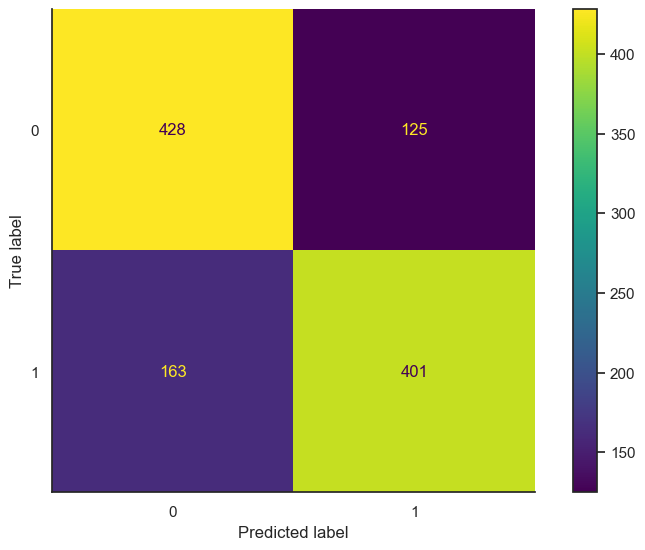

In [59]:
# Compute cm
cm = confusion_matrix(y_test, y_pred, labels=logreg_pipe.classes_)

# Create display 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_pipe.classes_)

# Plot the cm
disp.plot()
plt.show()

🔍 **Interpretation of Results**:
 - **True negatives (TN): 428** - The model correctly predicted class 0 🚫 for these instances.

- **False positives (FP): 125** - The model incorrectly predicted class 1 ✅ for these instances, which are actually class 0 🚫.

- **False negatives (FN): 163** - The model incorrectly predicted class 0 🚫 for these instances, which are actually class 1 ✅.

- **True positives (TP): 401** - The model correctly predicted class 1 ✅ for these instances.

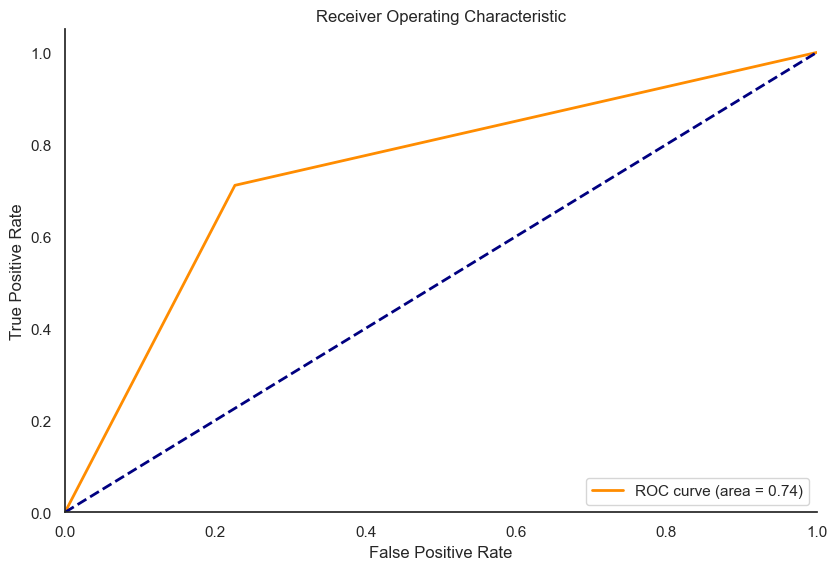

In [68]:
# Compute ROC curve and ROC area
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

🔍 **Interpretation of Results:**

**AUC(Ares Undert The ROC Curve): 0.74** - This indicates that the model possesses moderate discriminative power, meaning it can distinguish between positive and negative instances with a certain level of accuracy. While an AUC of 0.74 suggests that the model is reasonably effective in making predictions, there is room for improvement.


### Decision Tree

In [60]:
# Instantiate a Decision Tree model with random state = 42
dt_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Fit the training data to the pipeline
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [61]:
# Predict on the test set
y_pred = dt_pipe.predict(X_test)

#### Evaluation

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       553
           1       0.99      0.98      0.99       564

    accuracy                           0.99      1117
   macro avg       0.99      0.99      0.99      1117
weighted avg       0.99      0.99      0.99      1117



🔍 **Interpretation of Results**:

- **Precision:** Both classes (0 and 1) exhibit high precision, with 0.98 for class 0 and 0.99 for class 1. This indicates that, for class 0, 98% of the instances predicted as class 0 are indeed class 0, and for class 1, 99% of the instances predicted as class 1 are genuinely class 1.

- **Recall:** The recall scores for both classes are also impressive, with 0.99 for class 0 and 0.98 for class 1. This suggests that the model correctly identifies 99% of all actual class 0 instances and 98% of all actual class 1 instances.

- **F1-Score:** The F1-scores for both classes reach an exceptional 0.99, signifying a harmonious balance between precision and recall.

- **Accuracy:** The model demonstrates an impressive overall accuracy of 0.99, indicating that it makes the correct prediction for 99% of all instances.

- **Macro avg:** The macro average F1-score is 0.99, highlighting the model's outstanding performance when considering both classes equally.

- **Weighted avg:** The weighted average F1-score is also 0.99, reinforcing the model's consistent and robust performance across both classes.

In summary, this classification report reflects a model with outstanding precision, recall, and F1-scores for both classes, and a remarkable overall accuracy, showcasing its capability for accurate classification.

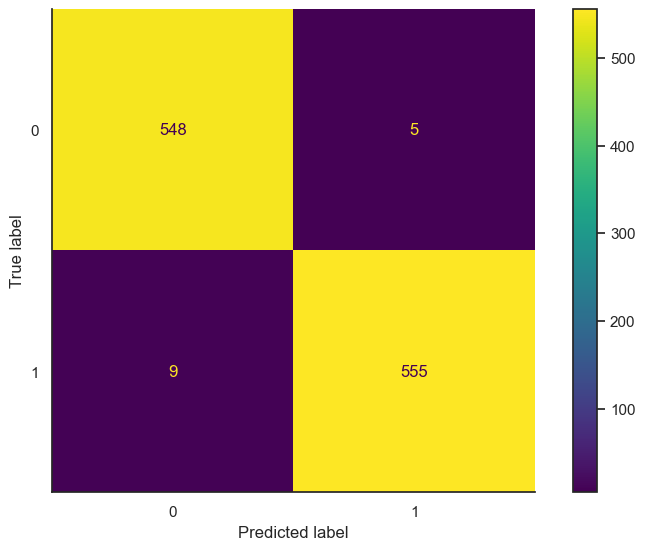

In [63]:
# Compute cm
cm = confusion_matrix(y_test, y_pred, labels=logreg_pipe.classes_)

# Create display 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_pipe.classes_)

# Plot the cm
disp.plot()
plt.show()

🔍 **Interpretation of Results**:
 - **True negatives (TN): 548** - The model correctly predicted class 0 🚫 for these instances.

- **False positives (FP): 5** - The model incorrectly predicted class 1 ✅ for these instances, which are actually class 0 🚫.

- **False negatives (FN): 9** - The model incorrectly predicted class 0 🚫 for these instances, which are actually class 1 ✅.

- **True positives (TP): 555** - The model correctly predicted class 1 ✅ for these instances.

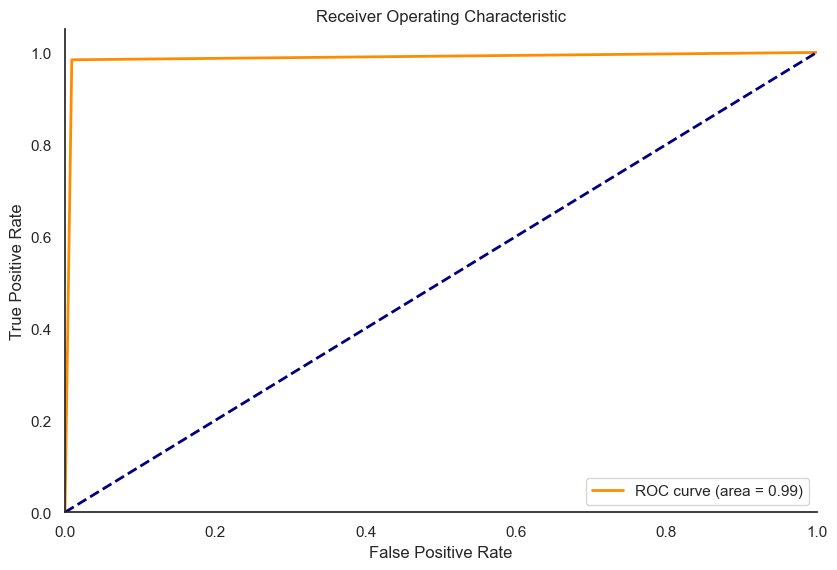

In [66]:
# Compute ROC curve and ROC area
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC curve
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_optimized)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

🔍 **Interpretation of Results:**

**AUC(Ares Undert The ROC Curve): 0.99** - This signifies that the model excels at distinguishing between the good and bad classes, with a high degree of accuracy.

#### Feature Importance

In [88]:
def rf_feat_imp(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.named_steps['dt'].feature_importances_}
                        ).sort_values('imp', ascending=False)

In [89]:
fi = rf_feat_imp(dt_pipe, X_test)
fi[:10]

,cols,imp
80,totaldue.perf,0.154347
43,customer_residency_Lagos,0.146956
83,age,0.109804
85,time_to_approval.perf,0.105985
2,bank_account_type_Savings,0.071212
86,employment_stability,0.053618
20,level_of_education_clients_Graduate,0.035071
3,bank_name_clients_Access Bank,0.025750
16,bank_name_clients_UBA,0.025569
9,bank_name_clients_GT Bank,0.025059


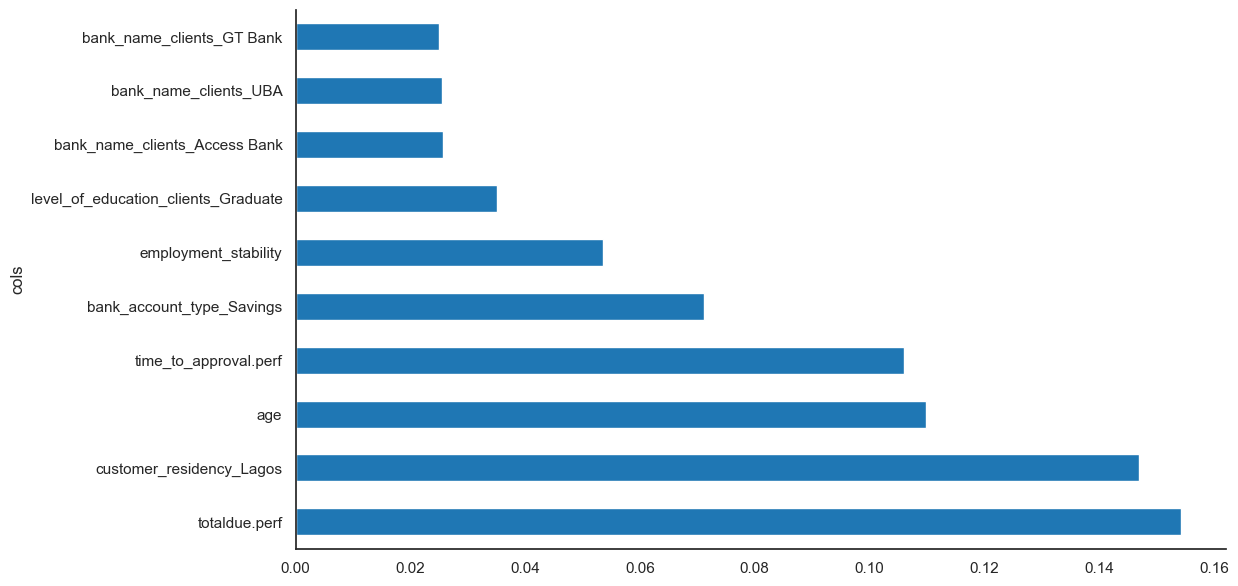

In [91]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

plot_fi(fi[:10]);

🔍 **Interpretation of Results**

Upon examining the feature importance plot of our decision tree model, it's evident that the most significant feature for making predictions is the amount that the customer owes to the bank. This feature holds the highest importance, indicating that it plays a crucial role in determining the outcomes of our model's decisions. Understanding the impact of this feature can provide valuable insights into the factors that influence our predictions and assist in making informed decisions in our analysis and modeling.
